In [5]:
import math
import os
import time

import matplotlib.pyplot as plt
import numpy as np
import ot as pot
import torch
from torch.distributions.multivariate_normal import MultivariateNormal


import torchdyn
from torchdyn.core import NeuralODE
from torchdyn.datasets import generate_moons

from torchcfm.conditional_flow_matching import *
from models_v2 import *
from torchcfm.utils import *

from tqdm import tqdm

savedir = "models/lin_pot_8gauss_moon"
os.makedirs(savedir, exist_ok=True)



In [6]:
# Problem set up

dim = 2
batch_size = 256
n_iters = 10_000

In [7]:
# Set up for reference distribution

mean = torch.zeros(dim)
cov = torch.eye(dim)

# Set up for reference distribution

ref_dist = MultivariateNormal(mean, cov)

Schrodinger bridge, I first want to see the difference between an OT matching and entropic matching. Then I want to see the difference between the boundary values for the SB bridge between the gaussians

In [8]:
sigma = 0.5
# model_ent_match = ResNet(dim= dim,hidden=2,time_varying= True)
model_ent_match = MLP(dim= dim,time_varying= True)
optimizer = torch.optim.Adam(model_ent_match.parameters(), lr=1e-3)
FM = SchrodingerBridgeConditionalFlowMatcher(sigma= sigma,ot_method= "sinkhorn")

for k in tqdm(range(n_iters)):
    optimizer.zero_grad()

    # x0 = ref_dist.sample((batch_size,))
    x0 = sample_moons(batch_size)
    x1 = sample_8gaussians(batch_size)

    t,xt,ut = FM.sample_location_and_conditional_flow(x0,x1)

    vt = model_ent_match(torch.cat([xt,t[:,None]],dim = -1))
    loss = torch.mean(torch.norm(vt - ut)**2)

    loss.backward()
    optimizer.step()

    if (k + 1) % 5000 == 0:
        node = NeuralODE(
            torch_wrapper(model_ent_match), solver="dopri5", sensitivity="adjoint", atol=1e-4, rtol=1e-4
        )
        with torch.no_grad():
            traj = node.trajectory(
                sample_moons(1000),
                t_span=torch.linspace(0, 1, 100),
            )
            plot_trajectories(traj.cpu().numpy())



  0%|          | 38/10000 [00:02<09:27, 17.55it/s]/work2/Sebas/anaconda3/envs/Hamiltonian_Flows_Wass/lib/python3.10/site-packages/ot/bregman.py:536: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "
  1%|          | 113/10000 [00:06<09:27, 17.41it/s]


KeyboardInterrupt: 

 25%|██▍       | 4993/20000 [00:47<02:24, 104.08it/s]

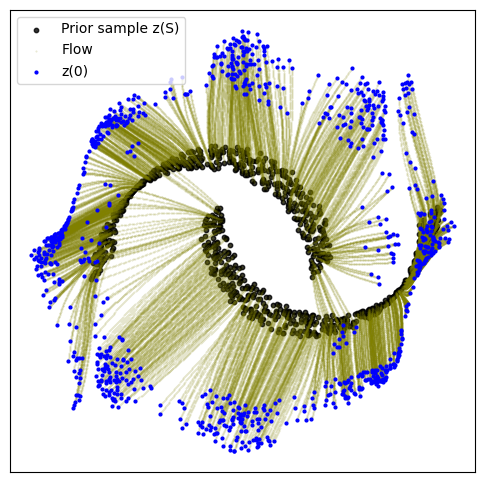

 50%|████▉     | 9998/20000 [01:38<01:35, 104.30it/s]

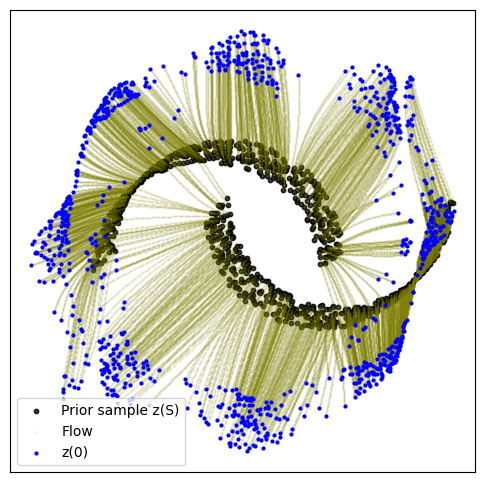

 75%|███████▍  | 14991/20000 [02:28<00:48, 104.12it/s]

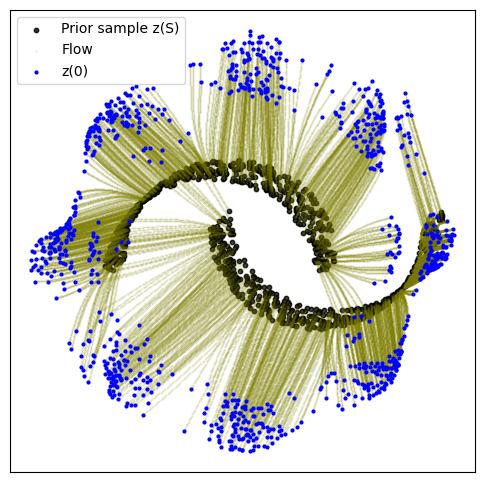

100%|█████████▉| 19996/20000 [03:17<00:00, 104.48it/s]

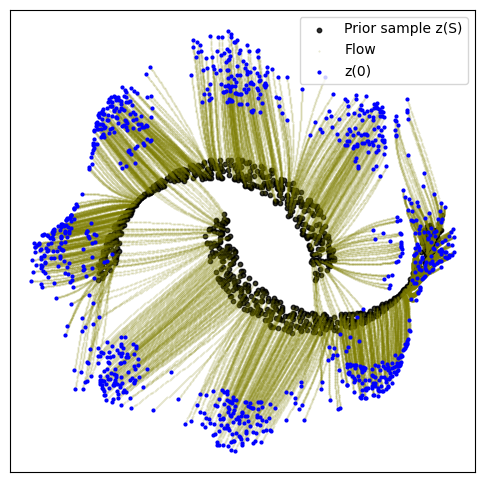

100%|██████████| 20000/20000 [03:19<00:00, 100.24it/s]


In [18]:
sigma = 0.5
model_ot_match = ResNet(dim= dim,hidden=2,time_varying= True)
optimizer = torch.optim.Adam(model_ot_match.parameters(), lr=1e-3)
FM = SchrodingerBridgeConditionalFlowMatcher(sigma= sigma)#,ot_method= "sinkhorn")

for k in tqdm(range(n_iters)):
    optimizer.zero_grad()

    # x0 = ref_dist.sample((batch_size,))
    x0 = sample_moons(batch_size)
    x1 = sample_8gaussians(batch_size)

    t,xt,ut = FM.sample_location_and_conditional_flow(x0,x1)

    vt = model_ot_match(torch.cat([xt,t[:,None]],dim = -1))
    loss = torch.mean(torch.norm(vt - ut)**2)

    loss.backward()
    optimizer.step()

    if (k + 1) % 5000 == 0:
        node = NeuralODE(
            torch_wrapper(model_ot_match), solver="dopri5", sensitivity="adjoint", atol=1e-4, rtol=1e-4
        )
        with torch.no_grad():
            traj = node.trajectory(
                sample_moons(1000),
                t_span=torch.linspace(0, 1, 100),
            )
            plot_trajectories(traj.cpu().numpy())



In [19]:
torch.save(model_ent_match.state_dict(), os.path.join(savedir, "model_ent_match.pt"))
torch.save(model_ot_match.state_dict(), os.path.join(savedir, "model_ot_match.pt"))

In [20]:
# model_ent_match = ResNet(dim= dim,hidden=1,time_varying= True)
# model_ot_match = ResNet(dim= dim,hidden=1,time_varying= True)

# model_ent_match.load_state_dict(torch.load(os.path.join(savedir, "model_ent_match.pt")))
# model_ot_match.load_state_dict(torch.load(os.path.join(savedir, "model_ot_match.pt")))


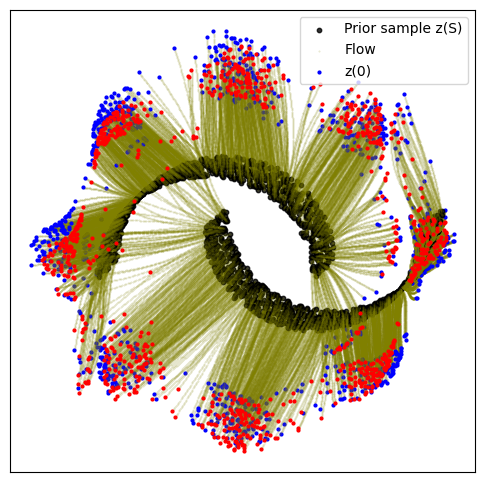

In [21]:
node_ot = NeuralODE(torch_wrapper(model_ot_match), solver="dopri5", sensitivity="adjoint", atol=1e-4, rtol=1e-4 )
node_ent = NeuralODE(torch_wrapper(model_ent_match), solver="dopri5", sensitivity="adjoint", atol=1e-4, rtol=1e-4 )
with torch.no_grad():
    traj_ot = node_ot.trajectory(sample_moons(1000),t_span=torch.linspace(0, 1, 100),)
    traj_ent = node_ent.trajectory(sample_moons(1000),t_span=torch.linspace(0, 1, 100),)
    # plot_trajectories(traj_ot.cpu().numpy())
    # plot_trajectories(traj_ent.cpu().numpy())
    compare_trajectories(traj_ot.cpu().numpy(),traj_ent.cpu().numpy())